In [1]:
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule
from fastmri.data import transforms, mri_data
import pathlib
import torch
import matplotlib.pyplot as plt
import numpy as np

def load_data_target () : 
    CHALLENGE = 'singlecoil'
    MASK_TYPE = 'random'
    center_fractions = [0.08]
    accelerations = [4]


    mask = create_mask_for_mask_type(
            MASK_TYPE, center_fractions, accelerations
        )

    train_transform = UnetDataTransform(CHALLENGE, mask_func=mask, use_seed=False)

    dataset = mri_data.SliceDataset(
        root=pathlib.Path(
          './fastmri_data/singlecoil_val'
        ),
        transform=train_transform,
        challenge='singlecoil'
    )

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=10)
    image, target, _, _, _, _, _ = next(iter(dataloader))

    return image, target

In [2]:
def imshow(target, result, epoch, loss) : 
    target_np = target.view(-1,320, 320).detach().cpu().numpy()[7]
    result_np = result.view(-1,320,320).detach().cpu().numpy()[7]

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(target_np)
    ax1.set_title('target mri image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(result_np)
    ax2.set_title('unet predict mri image')
    fig.suptitle("step:%d, loss:%.4f" % (epoch, loss))
    fig.show()
    plt.show()

In [3]:
image, target = load_data_target()

In [4]:

import InvertCnnConverter
import torch
import Unet
plain_model = Unet.UNet(n_channels=1, n_classes=1)
print(plain_model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [5]:
InvertCnnConverter.convert_module(plain_model, last_module_name='outc', inplace=True)
invert_model = plain_model

device = 'cuda:0'

invert_model = invert_model.to(device)
data = image.view(-1,1,320,320).to(device)
target = target.to(device)

print(invert_model)

UNet(
  (inc): CheckpointModule(
    (module): DoubleConv(
      (double_conv): Sequential(
        (0): RestoreClass(StitchableConv2d(in_channel=1, out_channel=64, kernel=3, stride=1, padding=1, fetch_shape=[128, 128])
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): RestoreClass(StitchableConv2d(in_channel=64, out_channel=64, kernel=3, stride=1, padding=1, fetch_shape=[128, 128])
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
  )
  (down1): CheckpointModule(
    (module): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): UpInvertibleBlock(
              (upscale): Upsample(scale_factor=(2.0, 1.0), mode=bilinear)
              (conv2): InvertibleModuleWrapper(
                

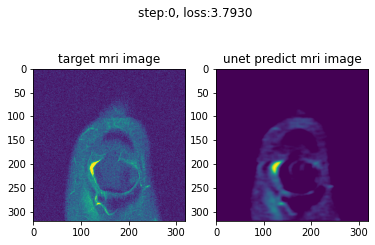

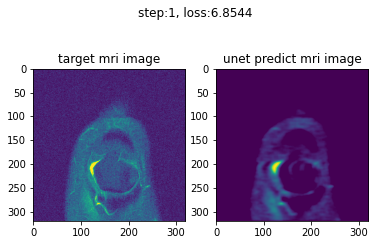

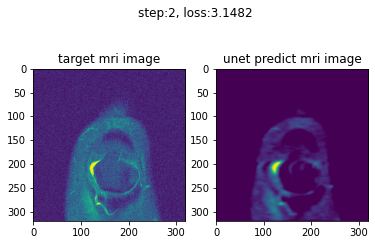

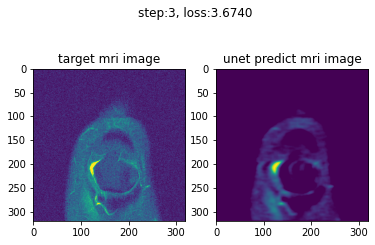

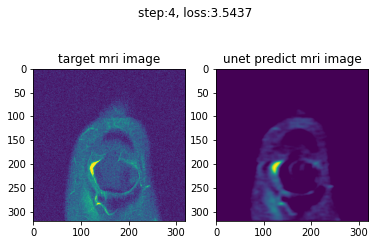

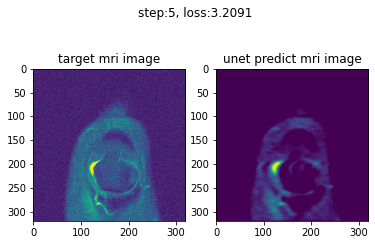

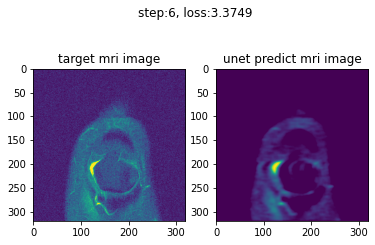

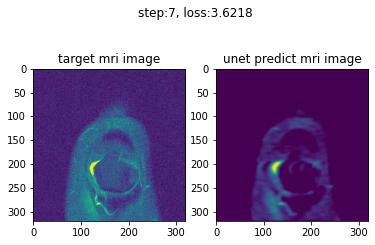

In [ ]:
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(invert_model.parameters(), lr=1e-2)
with torch.autograd.set_detect_anomaly(True) : 
    for epoch in range(10) : 
        result = invert_model(data)
        loss = criterion(result, target)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        imshow(target, result, epoch, loss.item())